In [1]:
%matplotlib inline

In [27]:
import salvus.namespace as sn
from salvus.mesh import simple_mesh
from salvus.mesh.unstructured_mesh import UnstructuredMesh
from salvus.flow import api
import numpy as np
import os
from matplotlib import pyplot as plt


import sys
sys.path.append('./mass/')
from elemental_matrices import get_jacobian
from basis_polynomials import lagrange_basis_derivative_matrix
# +
TENSOR_ORDER = int(os.environ.get("TENSOR_ORDER", 2))
NUM_RANKS = int(os.environ.get("NUM_RANKS", 8))
INITIAL_VALUES = True if int(os.environ.get("INITIAL_VALUES", 0)) == 1 else False
PRECONDITIONER = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True
MASS_SCALING = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True

MASS_SCALING=False

mflag = "w/" if MASS_SCALING else "w/o"
pflag = "w/" if PRECONDITIONER else "w/o"
iflag = "w/" if INITIAL_VALUES else "w/o"

VERBOSITY = int(os.environ.get("VERBOSITY", 0))
TOTAL_VOLUME = 1
print(
    f"Running 2D Cartesian Poisson problem on {NUM_RANKS} rank(s):\n"
    f"- order {TENSOR_ORDER},\n"
    f"- {mflag} mass scaling,\n"
    f"- {pflag} preconditioner,\n"
    f"- {iflag} initial values."
)
G = 6.67408*10**-11
M1 = 1/(4*np.pi*G)
M1 = 1

Running 2D Cartesian Poisson problem on 8 rank(s):
- order 1,
- w/o mass scaling,
- w/ preconditioner,
- w/o initial values.


In [9]:
def misfit(d_obs, U, A, P):
    return A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())


def gradient(mesh, field='rhs', order = 4, ndim=2):
    from basis_polynomials import lagrange_basis_derivative_matrix,  lagrange_basis_polynomials
    from quadrature_points_weights import gauss_lobatto_legendre_quadruature_points_weights, gauss_quadruature_points_weights
    assert(field in mesh.element_nodal_fields.keys())
    
    points = gauss_lobatto_legendre_quadruature_points_weights(order+1)[0]
    n = len(points)
    J = get_jacobian(mesh)
    l = np.identity(n)
    dl = lagrange_basis_derivative_matrix(points)

    result = np.zeros((mesh.nelem, n**2, 2))
    
    for nelem in range(mesh.nelem):
        derivative_u_local = np.zeros((n**2, ndim))
        uarr = mesh.element_nodal_fields[field][nelem]
        for j in np.arange(n):
            for i in np.arange(n):
                k = j*n + i
                derivative_u_local[k,0] = np.sum(uarr * dll(dl, l, i, j))
                derivative_u_local[k,1] = np.sum(uarr * dll(l, dl, i, j))
        for i in range(n**2):
            result[nelem,i] = np.linalg.inv(J[nelem,i]).dot(derivative_u_local[i])
        mesh.attach_field('grad_x', result[:,:,0])
        mesh.attach_field('grad_y', result[:,:,1])
    return result

In [33]:
def rhs_init_square(p):

    x = p[:, :, 0]
    y = p[:, :, 1]

    rhs = np.zeros_like(x)
    delta = 0.05
    mask = (x > 0.2 - delta) * (x < 0.2 + delta) * (y > 0.35 - delta) * (y < 0.35 + delta)
    rhs[mask] = 150.
    delta = 0.1
    mask = (x > 0.7 - delta) * (x < 0.7 + delta) * (y > 0.2 - delta) * (y < 0.2 + delta)
    rhs[mask] = 120.
    
    mask = (x > 0.6 - delta) * (x < 0.6 + delta) * (y > 0.7 - delta) * (y < 0.7 + delta)
    rhs[mask] = 80.
    
    return rhs

def rhs_init_quad(p):

    x = p[:, :, 0]
    y = p[:, :, 1]

    rhs = (1 - np.sqrt((x-0.5)**2 + (y-0.5)**2))*39.3
    
    return rhs

def rhs_init_uniform(p, const = 1.):
    assert(const != 0)
    x = p[:, :, 0]
    rhs = np.ones_like(x)*const
    
    return rhs

def simulation(mesh,  output_filename = "simulation.h5",input_filename = "rhs_2d.h5"):
    w = sn.simple_config.simulation.Poisson(mesh=mesh)
    w.domain.polynomial_order = mesh.shape_order

    w.physics.poisson_equation.right_hand_side.filename = input_filename 
    w.physics.poisson_equation.right_hand_side.format = "hdf5"
    w.physics.poisson_equation.right_hand_side.field = "rhs"

    w.physics.poisson_equation.solution.filename = output_filename
    w.physics.poisson_equation.mass_matrix_scaling = MASS_SCALING

    boundaries = sn.simple_config.boundary.HomogeneousDirichlet(
        side_sets=["x0", "x1", "y0", "y1"]
    )

    # Associate boundaries with our simulation.
    w.add_boundary_conditions(boundaries)

    w.solver.max_iterations = 300
    w.solver.absolute_tolerance = 0.0
    w.solver.relative_tolerance = 1e-10
    w.solver.preconditioner = PRECONDITIONER
    w.validate()
    # -

    api.run(
        input_file=w,
        site_name="local",
        output_folder="2d_simulation",
        overwrite=True,
        ranks=NUM_RANKS,
        verbosity=VERBOSITY,
    )
    

def new_mesh(rhs, output_filename="rhs_2d.h5"):
    m = simple_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=2.0, vs=1.0, rho=1.0, x_max=1.0, y_max=1.0, max_frequency=10.0)

    m.advanced.tensor_order = TENSOR_ORDER
    mesh = m.create_mesh()

    f = np.ones_like(mesh.elemental_fields["VP"])

    points = mesh.points[mesh.connectivity]

    mesh.elemental_fields = {}
    mesh.attach_field("M0", 1. * f)
    mesh.attach_field("M1", M1 * f)

    mesh.elemental_fields["fluid"] = np.ones([mesh.nelem])
    
    if type(rhs) == str:
        if rhs == 'init':
            rhs = rhs_init_uniform(points, const = 10**-5)
    else:
        rhs = rhs
        
    if rhs.shape != f.shape:
        rhs = rhs[mesh.connectivity]
    mesh.attach_field('fluid', np.ones(mesh.nelem))
    mesh.attach_field("rhs", rhs)
    mesh.write_h5(output_filename)
    return mesh

def new_mesh_obs(rhs, output_filename="rhs_obs.h5"):
    m = simple_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=2.0, vs=1.0, rho=1.0, x_max=1.0, y_max=1.0, max_frequency=10.0)

    m.advanced.tensor_order = TENSOR_ORDER
    mesh = m.create_mesh()

    f = np.ones_like(mesh.elemental_fields["VP"])

    points = mesh.points[mesh.connectivity]

    mesh.elemental_fields = {}
    mesh.attach_field("M0", 1.0 * f)
    mesh.attach_field("M1", M1  * f)

    mesh.elemental_fields["fluid"] = np.ones([mesh.nelem])
    
    rhs = rhs_init_square(points)
  #  rhs = rhs_init_quad(points)
    if rhs.shape != f.shape:
        rhs = rhs[mesh.connectivity]
    mesh.attach_field('fluid', np.ones(mesh.nelem))
    mesh.attach_field("rhs", rhs)
    mesh.write_h5(output_filename)
    return mesh

# def steplength_v2(J, grad_p, M, d_obs, A, P, sigmacoef=1):
#     c = J
#     b = np.linalg.norm(grad_p)
    
#     output_filename="sigma_test"
#     sigmatest = J * sigmacoef 
    
#     rhs = np.array(M + sigmatest * grad_p, dtype=np.float32)
#     mesh_test = new_mesh(rhs, output_filename="rhs_2d_test.h5")
#     simulation(mesh_test, output_filename, input_filename="rhs_2d_test.h5")
#     Utest = UnstructuredMesh.from_h5('2d_simulation/' + output_filename).element_nodal_fields['solution']
    
#     Jtest = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
    
#     a = sigmatest**(-2) * (Jtest - b * sigmatest - c) 
     
#     return (-0.5) * b / a

def compute_model(M, input_filename = "rhs_2d.h5", output_filename = "simulation"):
    rhs = np.array(M, dtype=np.float32)
    mesh = new_mesh(rhs, output_filename=input_filename)
    simulation(mesh, output_filename=output_filename, input_filename=input_filename)
    return UnstructuredMesh.from_h5('2d_simulation/' + output_filename).element_nodal_fields['solution']

def compute_forward(M, input_filename = "rhs_2d.h5", output_filename = "simulation"):
    rhs = np.array(M, dtype=np.float32)
    mesh = new_mesh(rhs, output_filename=input_filename)
    simulation(mesh, output_filename=output_filename, input_filename=input_filename)
    return UnstructuredMesh.from_h5('2d_simulation/' + output_filename).element_nodal_fields['solution']

def compute_gradient(V):
    mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
    simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']
    Z = np.zeros_like(mesh_a.points[:,0])
    Z[mesh_a.connectivity] = adjoint
    return -1./M1 * Z

def steplength_v2(J, grad_p, M, V, d_obs, A, P, coef):
    c = J
    b = np.linalg.norm(grad_p)

    sigmatest =np.max(np.abs(V))* coef#np.max(np.abs(V))*coef
    Utest = compute_model(M + sigmatest * (-1) * gradJ,  output_filename = "sigmatest")
    
    Jtest = misfit(d_obs, Utest, A, P)
    
    a = sigmatest**(-2) * (Jtest - b*sigmatest - c) 
    return (-0.5) * b / a

def wolfe_conditions(Mtest, J, grad_p, gradJ, sigma, c1=10**(-4), c2=0.1):
    Utest = compute_model(Mtest)
    Jtest = misfit(d_obs, Utest, A, P)
    V = d_obs - Utest
    adjoint = compute_model(V, input_filename = "adj_rhs_2d.h5", output_filename = "simulation_adjoint")
    Z = np.zeros_like(mesh_obs.points[:,0])
    gradJtest = np.zeros_like(mesh_obs.points[:,0])
    Z[mesh_obs.connectivity] = adjoint
    gradJtest = -1./ M1 * Z 
    
    armijo = Jtest <= (J + c1 * sigma * gradJ.T.dot(grad_p))
    curvature = np.abs(gradJtest.T.dot(grad_p)) <= (-1)*c2*gradJ.T.dot(grad_p)
    
    if armijo and curvature:
        return True
    else:
        print(f'armijo:{armijo}, curvature:{curvature}')
        return False
    
def armijo_condition(Mtest, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = True):
    Utest = compute_model(Mtest)
    Jtest = misfit(d_obs, Utest, A, P)
    if curvat:
        print(f'curvature condition: {curvature_condition(Utest, gradJ, sigma)}')
    
    #if Jtest <= (J + c1 * sigma * np.linalg.norm(grad_p)):
    if Jtest <= (J + c1 * sigma * gradJ.T.dot(grad_p/np.linalg.norm(grad_p))):
        return True
    else:
        print(Jtest, J, c1 * sigma * gradJ.T.dot(grad_p/np.linalg.norm(grad_p)))
        return False
    
def curvature_condition(Utest, gradJ, sigma, c2=0.1):
    V = d_obs - Utest
    adjoint = compute_model(V, input_filename = "adj_rhs_2d.h5", output_filename = "simulation_adjoint")
    
    Z = np.zeros_like(mesh_obs.points[:,0])
    gradJtest = np.zeros_like(mesh_obs.points[:,0])
    
    Z[mesh_obs.connectivity] = adjoint

    gradJtest = -1./ M1 * Z 
    
    if gradJtest.T.dot(gradJ) >= c2*gradJ.T.dot((-1)*gradJ):
        return True
    else: return False
    
def test_steplength(M, sigma, J, h_prev):
    M += sigma * h_prev 
    mesh_f = new_mesh(M[mesh_f.connectivity])
    simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    Jtest = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
    if Jtest < J:
        return True
    else:
        return False
    
def dll(dl,l, nx, ny):
    #param: nx and ny are the coordinates of the nodal point in the local c.s.
    #return: 
    n = dl.shape[0]
    l_local = np.zeros(n**2)
    for j in range(n):
        for i in range(n):
            k = j*5 + i
            l_local[k] = dl[nx, i]*l[ny, j]
    return l_local

In [34]:
# mesh_f = new_mesh('init')
# simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")

# mesh_i = mesh_f.copy()
# sol_i = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")

#d_obs:
mesh_obs = new_mesh_obs('init')
simulation(mesh_obs, output_filename='obs.h5', input_filename='rhs_obs.h5')
d_obs = UnstructuredMesh.from_h5("2d_simulation/obs.h5").element_nodal_fields['solution']
mesh_obs.attach_field('gravpot', d_obs)
mesh_obs.write_h5('mesh_obs.h5')

In [74]:
#nodal points array raveled
D = d_obs.ravel()
N_d_nodes = D.shape[0]

#Picking the meaningful observational points. A maps N_d_nodes -> N_d_obs
N_d_obs = N_d_nodes
A = np.zeros((N_d_obs, N_d_nodes))
if N_d_obs == N_d_nodes:
    A = np.identity(N_d_nodes) 

# for i in range(0,N_d_obs, 25):
#     A[i,i] = 1
P = np.identity(N_d_obs)

J_arr = []
gradJ_arr = []

#Inverse problem (conjugate gradient from Fichtner 2011):
#zeroth step:
M = np.ones(mesh_obs.points.shape[0])*10**-2
U = compute_forward(M)
#U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
V = d_obs - U
print('V',np.mean(V))
J = misfit(d_obs, U, A, P) 
J_arr.append(J)
print('J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))

gradJ = compute_gradient(V)
h_prev = (-1)*gradJ
gradJ_norm_prev = np.linalg.norm(gradJ)

V 0.321977539069
J 26.1314470578 rel J 1.26697925129


In [75]:
gradtest = np.zeros_like(M)
for i in range(5,M.shape[0]-5):
    d = 0.01
    Mtest = M.copy()
    Mtest[i] += d
    Utest = compute_forward(Mtest)
    Jtest = misfit(d_obs, Utest, A, P)
    gradtest[i] = (J - Jtest)/d

In [77]:
gradtest/gradJ

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([        nan,         nan,         nan,         nan,         nan,
               nan, -7.99900683, -7.99876819, -7.99840861,         nan,
               nan, -7.99937499, -7.99906546, -7.99876819,         nan,
               nan, -7.99966636, -7.99937499, -7.99900683,         nan,
               nan,         nan,         nan,         nan,         nan])

In [78]:
mesh_obs.connectivity

array([[ 0,  5,  1,  6],
       [ 5, 10,  6, 11],
       [10, 15, 11, 16],
       [15, 20, 16, 21],
       [ 1,  6,  2,  7],
       [ 6, 11,  7, 12],
       [11, 16, 12, 17],
       [16, 21, 17, 22],
       [ 2,  7,  3,  8],
       [ 7, 12,  8, 13],
       [12, 17, 13, 18],
       [17, 22, 18, 23],
       [ 3,  8,  4,  9],
       [ 8, 13,  9, 14],
       [13, 18, 14, 19],
       [18, 23, 19, 24]])

In [47]:
mesh_obs.connectivity.shape

(16, 4)

In [16]:
np.where(gradJ == np.min(gradJ))

(array([921]),)

In [7]:
niter=100
M = np.zeros(mesh_obs.points.shape[0])
for i in range(niter):
    J_arr.append(J)
    gradJ_arr.append(gradJ_norm_prev)
    #M[mesh_obs.connectivity] = mesh_.elemental_fields['rhs']
    
    grad_p = h_prev 

    coef = 1000.
    sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)
    while not armijo_condition(M+sigma * grad_p, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = False):
        print('false armijo', coef)
        coef /= 2.
        sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)

    #update model:
    M += sigma * grad_p
    
    #new forward simulation

    U = compute_forward(M)
    
    #find new model gradient:
    
    J = misfit(d_obs, U, A, P)
    print(i, 'J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))
    
    V = d_obs - U
    
    gradJ = compute_gradient(V)
    gradJ_norm_new = np.linalg.norm(gradJ)
    
    #find a new direction:
    h_new = (-1) * gradJ + gradJ_norm_new**2 / gradJ_norm_prev**2 * h_prev
    gradJ_norm_prev = gradJ_norm_new
    h_prev = h_new



fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
ax1.plot(J_arr)
ax1.set_xlabel('iteration')
ax1.set_ylabel('J')

ax2.plot(gradJ_arr)
ax2.set_xlabel('iteration')
ax2.set_ylabel('L2(grad)')





# sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
# final_U = sol.element_nodal_fields['solution']
# mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
# mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])
# mesh_f.write_h5('test.h5')

#   new forward simulation
#     mesh_f = new_mesh(M[mesh_f.connectivity])
#     simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
#     U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']

2839.65519768 1017.1724511 0.0293040567718
false armijo 1000.0
0 J 297.070326155 rel J 0.1980863223
917.712867567 297.070326155 -0.0390280154687
false armijo 1000.0
1 J 132.625767504 rel J 0.0884347853489
2 J 101.699763724 rel J 0.0678133438489
3 J 93.2276822918 rel J 0.0621641648318
4 J 61.4279474123 rel J 0.0409601199381
5 J 49.2431609638 rel J 0.0328353113554
6 J 46.4082744252 rel J 0.030945010645
7 J 42.674831183 rel J 0.0284555528424
8 J 37.8877986562 rel J 0.025263562312
9 J 34.0210087831 rel J 0.0226851890527
10 J 31.3766446134 rel J 0.0209219285481
11 J 28.7389725066 rel J 0.0191631303072
12 J 25.8182284508 rel J 0.0172155798538
13 J 23.1210920599 rel J 0.0154171308625
14 J 21.0412267979 rel J 0.0140302779043
15 J 19.3015324807 rel J 0.012870250736
16 J 17.6295754934 rel J 0.0117553907804
17 J 16.0551734469 rel J 0.010705580403
18 J 14.7749171252 rel J 0.00985190622535
19 J 13.8200804718 rel J 0.00921522169507
20 J 13.0372660224 rel J 0.00869324147129
21 J 12.3023907953 rel J 0

Traceback (most recent call last):
  File "salvus/flow/api.py", line 545, in salvus.flow.api.run
  File "salvus/flow/sites/job.py", line 418, in salvus.flow.sites.job.Job.wait
KeyboardInterrupt


--------------------
Please hang on - cancelling job ...

💥  Cancelled job_2110261836099562_8d42984310@local

🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/stdout ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/input/mesh.h5 ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/input/input.toml ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/input/rhs_2d.h5 ...
🗑  Deleting folder /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/input ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/stderr ...
🗑  Deleting folder /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/output ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2110261836099562_8d42984310/run_binary.sh ...
🗑  Deleting file   /Users/andrei/salvus_da

KeyboardInterrupt: 

In [11]:
A

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

V 0.416583359593
J 40.2554426503 rel J 0.671262874407
41.7075004578 40.2554426503 -0.0801926608847
false armijo 1000.0 -1.02140700675
0 J 5.05618231834 rel J 0.0843122632141
1 J 3.70589660381 rel J 0.0617961359445
2 J 3.09904570793 rel J 0.0516768464799
3 J 2.32330881645 rel J 0.0387413689079
4 J 1.98954119044 rel J 0.0331757658175
5 J 1.73801019739 rel J 0.0289814654626
6 J 1.52328919891 rel J 0.0254009748469
7 J 1.38654904712 rel J 0.0231208213747
8 J 1.28163131238 rel J 0.0213713093692
9 J 1.17003649007 rel J 0.01951045637
10 J 1.05225414081 rel J 0.0175464258411
11 J 0.946940831554 rel J 0.0157903175976
12 J 0.856748149871 rel J 0.0142863470841
13 J 0.772697327013 rel J 0.0128847925803
14 J 0.694028287972 rel J 0.011572979772
15 J 0.628599990468 rel J 0.0104819574366
16 J 0.579978341474 rel J 0.00967118737144
17 J 0.542629104253 rel J 0.00904838571573
18 J 0.510371202327 rel J 0.00851048250207
19 J 0.48066306795 rel J 0.00801509687562
20 J 0.453779688311 rel J 0.00756681427078
21 J

Text(0, 0.5, 'L2(grad)')

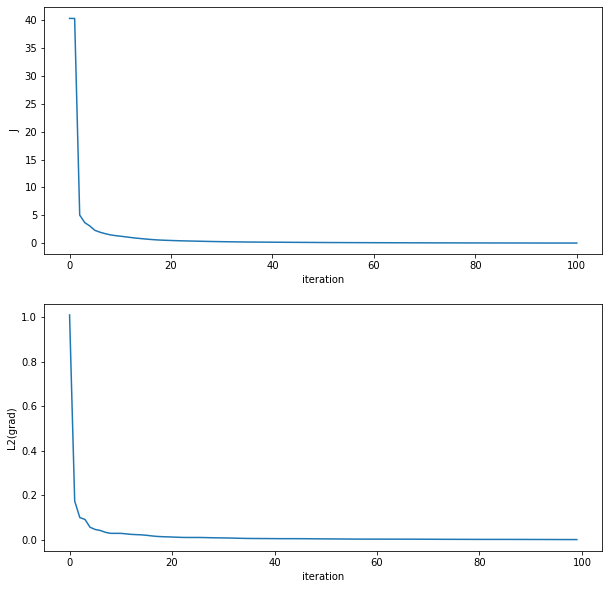

In [20]:
mesh_f = new_mesh('init')
simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")

mesh_i = mesh_f.copy()
sol_i = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")

#d_obs:
mesh_obs = new_mesh_obs('init')
simulation(mesh_f, output_filename='obs.h5', input_filename='rhs_obs.h5')
d_obs = UnstructuredMesh.from_h5("2d_simulation/obs.h5").element_nodal_fields['solution']
mesh_obs.attach_field('gravpot', d_obs)
mesh_obs.write_h5('mesh_obs.h5')

#nodal points array raveled
D = d_obs.ravel()
N_d_nodes = D.shape[0]

#Picking the meaningful observational points. A maps N_d_nodes -> N_d_obs
N_d_obs = N_d_nodes
A = np.zeros((N_d_obs, N_d_nodes))
# if N_d_obs == N_d_nodes:
#     A = np.identity(N_d_nodes) 

for i in range(0, N_d_obs, 25):
    A[i,i] = 1
P = np.identity(N_d_obs)

J_arr = []
gradJ_arr = []

#Inverse problem (conjugate gradient from Fichtner 2011):
#zeroth step:
U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
V = d_obs - U
print('V',np.mean(V))
J = misfit(d_obs, U, A, P) 
J_arr.append(J)
print('J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))

mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']

Z = np.zeros_like(mesh_a.points[:,0])
M = np.zeros_like(mesh_a.points[:,0])
Z[mesh_a.connectivity] = adjoint

gradJ = -1./M1 * Z
h_prev = (-1)*gradJ
gradJ_norm_prev = np.linalg.norm(gradJ)

niter=100
for i in range(niter):
    J_arr.append(J)
    gradJ_arr.append(gradJ_norm_prev)
    #find the optimal steplength sigma:
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']
    M[M<0] = 0
    
    grad_p = h_prev 

    coef = 1000.
    sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)
    while not armijo_condition(M+sigma * grad_p, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = False):
        print('false armijo', coef, gradJ.T.dot(grad_p))
        coef *= 0.5
        sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)
#    print('armijo', coef, armijo_condition(M+sigma * grad_p, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = False))
    #update model:
    M += sigma * grad_p
    
  #  print('gradJ:',np.mean(gradJ), sigma, np.mean(M))
    #new forward simulation
    mesh_f = new_mesh(M[mesh_f.connectivity])
    simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
    
    #find new model gradient:
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    J = misfit(d_obs, U, A, P)
    print(i, 'J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))
#     THRESHOLD = 0.01
#     if J/J_arr[0] < THRESHOLD:
#         break
    V = d_obs - U
    
    mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
    simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']
    
    Z = np.zeros_like(mesh_a.points[:,0])
    Z[mesh_a.connectivity] = adjoint
    
    gradJ = -1./M1 * Z
    gradJ_norm_new = np.linalg.norm(gradJ)
    
    #find a new direction:
    h_new = (-1) * gradJ + gradJ_norm_new**2 / gradJ_norm_prev**2 * h_prev
    gradJ_norm_prev = gradJ_norm_new
    h_prev = h_new

# sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
# final_U = sol.element_nodal_fields['solution']
# mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
# mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])
# mesh_f.write_h5('test.h5')

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
ax1.plot(J_arr)
ax1.set_xlabel('iteration')
ax1.set_ylabel('J')

ax2.plot(gradJ_arr)
ax2.set_xlabel('iteration')
ax2.set_ylabel('L2(grad)')

In [21]:
mesh_f = new_mesh('init')
simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")

mesh_i = mesh_f.copy()
sol_i = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")

#d_obs:
mesh_obs = new_mesh_obs('init')
simulation(mesh_f, output_filename='obs.h5', input_filename='rhs_obs.h5')
d_obs = UnstructuredMesh.from_h5("2d_simulation/obs.h5").element_nodal_fields['solution']
mesh_obs.attach_field('gravpot', d_obs)
mesh_obs.write_h5('mesh_obs.h5')

#nodal points array raveled
D = d_obs.ravel()
N_d_nodes = D.shape[0]

#Picking the meaningful observational points. A maps N_d_nodes -> N_d_obs
N_d_obs = N_d_nodes
A = np.zeros((N_d_obs, N_d_nodes))
# if N_d_obs == N_d_nodes:
#     A = np.identity(N_d_nodes) 


A[35,35] = 1
P = np.identity(N_d_obs)

J_arr = []
gradJ_arr = []

#Inverse problem (conjugate gradient from Fichtner 2011):
#zeroth step:
U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
V = d_obs - U
print('V',np.mean(V))
J = misfit(d_obs, U, A, P) 
J_arr.append(J)
print('J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))

mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']

Z = np.zeros_like(mesh_a.points[:,0])
M = np.zeros_like(mesh_a.points[:,0])
Z[mesh_a.connectivity] = adjoint

gradJ = -1./M1 * Z
h_prev = (-1)*gradJ
gradJ_norm_prev = np.linalg.norm(gradJ)

niter=100
for i in range(niter):
    J_arr.append(J)
    gradJ_arr.append(gradJ_norm_prev)
    #find the optimal steplength sigma:
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']
    
    grad_p = h_prev 

    coef = 1000.
    sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)
    while not armijo_condition(M+sigma * grad_p, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = False):
        print('false armijo', coef, gradJ.T.dot(grad_p))
        coef *= 0.5
        sigma = steplength_v2(J, grad_p, M, V, d_obs, A, P, coef=coef)
#    print('armijo', coef, armijo_condition(M+sigma * grad_p, J, gradJ, grad_p, sigma, c1=10**(-4), curvat = False))
    #update model:
    M += sigma * grad_p
    
  #  print('gradJ:',np.mean(gradJ), sigma, np.mean(M))
    #new forward simulation
    mesh_f = new_mesh(M[mesh_f.connectivity])
    simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
    
    #find new model gradient:
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    J = misfit(d_obs, U, A, P)
    print(i, 'J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))
#     THRESHOLD = 0.01
#     if J/J_arr[0] < THRESHOLD:
#         break
    V = d_obs - U
    
    mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
    simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']
    
    Z = np.zeros_like(mesh_a.points[:,0])
    M = np.zeros_like(mesh_a.points[:,0])
    Z[mesh_a.connectivity] = adjoint
    
    gradJ = -1./M1 * Z
    gradJ_norm_new = np.linalg.norm(gradJ)
    
    #find a new direction:
    h_new = (-1) * gradJ + gradJ_norm_new**2 / gradJ_norm_prev**2 * h_prev
    gradJ_norm_prev = gradJ_norm_new
    h_prev = h_new

# sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
# final_U = sol.element_nodal_fields['solution']
# mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
# mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])
# mesh_f.write_h5('test.h5')

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
ax1.plot(J_arr)
ax1.set_xlabel('iteration')
ax1.set_ylabel('J')

ax2.plot(gradJ_arr)
ax2.set_xlabel('iteration')
ax2.set_ylabel('L2(grad)')

V 0.416583359593
J 0.00482469460343 rel J 0.0694599066618
0.0076868974 0.00482469460343 -0.0693452534255
false armijo 1000.0 -1.02140700675
8.28949826757e-05 0.00482469460343 -0.0346713921867
false armijo 500.0 -1.02140700675
0.000910734377558 0.00482469460343 -0.0173353874783
false armijo 250.0 -1.02140700675
0.00248196998749 0.00482469460343 -0.00866761658747
false armijo 125.0 -1.02140700675
0.00355689874579 0.00482469460343 -0.00433378900607
false armijo 62.5 -1.02140700675
0.00416668861025 0.00482469460343 -0.00216688968115
false armijo 31.25 -1.02140700675
0.00448966463079 0.00482469460343 -0.00108344363511
false armijo 15.625 -1.02140700675
0.0046556728774 0.00482469460343 -0.000541721516187
false armijo 7.8125 -1.02140700675
0.00473980706115 0.00482469460343 -0.000270860682752
false armijo 3.90625 -1.02140700675
0.00478215666258 0.00482469460343 -0.000135430322541
false armijo 1.953125 -1.02140700675
0.00480340209119 0.00482469460343 -6.77151565617e-05
false armijo 0.9765625 -1

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.641767935156351e-155 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8208839675781755e-155 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.104419837890877e-156 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.5522099189454387e-156 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2761049594727193e-156 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1380524797363597e-156 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.6902623986817984e-157 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.8451311993408992e-157 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.4225655996704496e-157 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.112827998352248e-158 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.556413999176124e-158 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.778206999588062e-158 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.89103499794031e-159 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.445517498970155e-159 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2227587494850775e-159 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1113793747425387e-159 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.556896873712694e-160 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.778448436856347e-160 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3892242184281734e-160 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.946121092140867e-161 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.4730605460704336e-161 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7365302730352168e-161 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.682651365176084e-162 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.341325682588042e-162 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.170662841294021e-162 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0853314206470105e-162 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.4266571032350524e-163 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.7133285516175262e-163 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3566642758087631e-163 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.7833213790438156e-164 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.3916606895219078e-164 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6958303447609539e-164 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.479151723804769e-165 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.2395758619023847e-165 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.1197879309511924e-165 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0598939654755962e-165 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.299469827377981e-166 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6497349136889905e-166 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3248674568444952e-166 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.624337284222476e-167 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.312168642111238e-167 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.656084321055619e-167 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.280421605278095e-168 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.1402108026390476e-168 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0701054013195238e-168 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0350527006597619e-168 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.1752635032988095e-169 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5876317516494047e-169 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2938158758247024e-169 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.469079379123512e-170 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.234539689561756e-170 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.617269844780878e-170 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.08634922390439e-171 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.043174611952195e-171 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0215873059760975e-171 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0107936529880487e-171 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.0539682649402436e-172 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5269841324701218e-172 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2634920662350609e-172 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.3174603311753045e-173 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.1587301655876523e-173 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5793650827938261e-173 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.896825413969131e-174 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.9484127069845653e-174 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9742063534922827e-174 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.871031767461413e-175 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.9355158837307067e-175 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.4677579418653533e-175 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2338789709326767e-175 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.169394854663383e-176 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.0846974273316917e-176 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5423487136658458e-176 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.711743568329229e-177 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.8558717841646146e-177 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9279358920823073e-177 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.639679460411536e-178 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.819839730205768e-178 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.409919865102884e-178 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.204959932551442e-178 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.02479966275721e-179 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.012399831378605e-179 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5061999156893026e-179 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.530999578446513e-180 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.7654997892232564e-180 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8827498946116282e-180 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.413749473058141e-181 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.7068747365290705e-181 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.3534373682645353e-181 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1767186841322676e-181 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.883593420661338e-182 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.941796710330669e-182 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.4708983551653345e-182 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.354491775826673e-183 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.6772458879133364e-183 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8386229439566682e-183 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.193114719783341e-184 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.5965573598916705e-184 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2982786799458352e-184 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1491393399729176e-184 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.745696699864588e-185 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.872848349932294e-185 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.436424174966147e-185 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.182120874830735e-186 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.5910604374153675e-186 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7955302187076838e-186 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.977651093538419e-187 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.4888255467692094e-187 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2444127733846047e-187 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1222063866923024e-187 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.611031933461512e-188 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.805515966730756e-188 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.402757983365378e-188 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.01378991682689e-189 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.506894958413445e-189 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7534474792067224e-189 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.767237396033612e-190 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.383618698016806e-190 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.191809349008403e-190 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0959046745042015e-190 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.4795233725210076e-191 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.7397616862605038e-191 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3698808431302519e-191 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.8494042156512595e-192 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.4247021078256297e-192 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7123510539128149e-192 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.561755269564074e-193 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.280877634782037e-193 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.1404388173910186e-193 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0702194086955093e-193 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.3510970434775465e-194 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6755485217387732e-194 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3377742608693866e-194 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.688871304346933e-195 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.3444356521734666e-195 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6722178260867333e-195 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.361089130433666e-196 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.180544565216833e-196 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0902722826084166e-196 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0451361413042083e-196 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.2256807065210415e-197 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6128403532605207e-197 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3064201766302604e-197 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.532100883151302e-198 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.266050441575651e-198 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6330252207878255e-198 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.165126103939127e-199 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.0825630519695637e-199 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0412815259847818e-199 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0206407629923909e-199 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.1032038149619546e-200 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5516019074809773e-200 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2758009537404886e-200 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.379004768702443e-201 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.1895023843512216e-201 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5947511921756108e-201 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.973755960878054e-202 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.986877980439027e-202 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9934389902195135e-202 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.967194951097568e-203 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.983597475548784e-203 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.491798737774392e-203 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.245899368887196e-203 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.22949684443598e-204 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.11474842221799e-204 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.557374211108995e-204 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.786871055544975e-205 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.8934355277724873e-205 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9467177638862437e-205 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.733588819431218e-206 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.866794409715609e-206 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.4333972048578046e-206 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2166986024289023e-206 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.0834930121445114e-207 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.0417465060722557e-207 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5208732530361279e-207 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.604366265180639e-208 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.8021831325903196e-208 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9010915662951598e-208 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.505457831475799e-209 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.7527289157378996e-209 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.3763644578689498e-209 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1881822289344749e-209 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.9409111446723744e-210 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.9704555723361872e-210 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.4852277861680936e-210 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.426138930840468e-211 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.713069465420234e-211 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.856534732710117e-211 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.282673663550585e-212 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.6413368317752925e-212 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.3206684158876463e-212 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1603342079438231e-212 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.801671039719116e-213 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.900835519859558e-213 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.450417759929779e-213 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.252088799648895e-214 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.6260443998244473e-214 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8130221999122236e-214 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.065110999561118e-215 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.532555499780559e-215 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2662777498902796e-215 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1331388749451398e-215 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.665694374725699e-216 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.8328471873628494e-216 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.4164235936814247e-216 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.082117968407124e-217 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.541058984203562e-217 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.770529492101781e-217 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.852647460508905e-218 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.4263237302544523e-218 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2131618651272261e-218 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1065809325636131e-218 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.5329046628180653e-219 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.7664523314090327e-219 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3832261657045163e-219 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.916130828522582e-220 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.458065414261291e-220 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7290327071306454e-220 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.645163535653227e-221 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.3225817678266135e-221 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.1612908839133068e-221 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0806454419566534e-221 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.403227209783267e-222 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.7016136048916335e-222 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3508068024458167e-222 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.754034012229084e-223 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.377017006114542e-223 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.688508503057271e-223 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.442542515286355e-224 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.2212712576431773e-224 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.1106356288215886e-224 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0553178144107943e-224 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.2765890720539716e-225 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6382945360269858e-225 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3191472680134929e-225 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.5957363400674645e-226 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.2978681700337323e-226 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6489340850168661e-226 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.244670425084331e-227 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.1223352125421653e-227 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0611676062710827e-227 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0305838031355413e-227 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.1529190156777066e-228 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5764595078388533e-228 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2882297539194267e-228 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.441148769597133e-229 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.2205743847985667e-229 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6102871923992833e-229 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.051435961996417e-230 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.0257179809982083e-230 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0128589904991042e-230 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0064294952495521e-230 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.0321474762477604e-231 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5160737381238802e-231 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2580368690619401e-231 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.2901843453097005e-232 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.1450921726548502e-232 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5725460863274251e-232 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.862730431637126e-233 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.931365215818563e-233 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9656826079092814e-233 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.828413039546407e-234 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.9142065197732035e-234 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.4571032598866018e-234 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2285516299433009e-234 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.1427581497165044e-235 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.0713790748582522e-235 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5356895374291261e-235 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.6784476871456305e-236 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.8392238435728152e-236 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9196119217864076e-236 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.598059608932038e-237 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.799029804466019e-237 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.3995149022330095e-237 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1997574511165048e-237 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.998787255582524e-238 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.999393627791262e-238 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.499696813895631e-238 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.498484069478155e-239 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.7492420347390774e-239 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8746210173695387e-239 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.373105086847693e-240 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.686552543423847e-240 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.3432762717119234e-240 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1716381358559617e-240 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.8581906792798084e-241 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.9290953396399042e-241 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.4645476698199521e-241 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.3227383490997605e-242 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.6613691745498803e-242 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.8306845872749401e-242 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.153422936374701e-243 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.5767114681873503e-243 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2883557340936752e-243 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1441778670468376e-243 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.720889335234188e-244 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.860444667617094e-244 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.430222333808547e-244 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.151111669042735e-245 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.5755558345213674e-245 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7877779172606837e-245 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.938889586303419e-246 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.4694447931517093e-246 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.2347223965758547e-246 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.1173611982879273e-246 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.5868059914396366e-247 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.7934029957198183e-247 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3967014978599092e-247 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.983507489299546e-248 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.491753744649773e-248 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.7458768723248864e-248 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.729384361624432e-249 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.364692180812216e-249 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.182346090406108e-249 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.091173045203054e-249 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.45586522601527e-250 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.727932613007635e-250 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3639663065038175e-250 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.819831532519088e-251 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.409915766259544e-251 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.704957883129772e-251 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.52478941564886e-252 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.26239470782443e-252 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.131197353912215e-252 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0655986769561075e-252 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.327993384780537e-253 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6639966923902686e-253 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3319983461951343e-253 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.6599917309756716e-254 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.3299958654878358e-254 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6649979327439179e-254 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.324989663719589e-255 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.1624948318597947e-255 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0812474159298974e-255 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0406237079649487e-255 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.2031185398247434e-256 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.6015592699123717e-256 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.3007796349561859e-256 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.503898174780929e-257 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.2519490873904646e-257 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.6259745436952323e-257 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 8.129872718476162e-258 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.064936359238081e-258 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.0324681796190404e-258 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.0162340898095202e-258 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 5.081170449047601e-259 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.5405852245238005e-259 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.2702926122619002e-259 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 6.351463061309501e-260 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.1757315306547506e-260 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.5878657653273753e-260 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 7.9393288266368765e-261 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 3.9696644133184383e-261 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 1.9848322066592191e-261 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 9.924161033296096e-262 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 4.962080516648048e-262 -1.02140700675


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: overflow encountered in double_scalars


0.00482469460343 0.00482469460343 0.0
false armijo 2.481040258324024e-262 -1.02140700675


ValueError: Job finished with status `JobStatus.unknown`.

    stdout:

===============================================================
Salvus (c) Mondaic Ltd. (2021)
===============================================================
version: 0.11.40-21-gd1d7bbc2
===============================================================
Architecture: haswell
Floating point size: 64
Integer size: 64
Alignment: 32
Running on 8 rank(s).
===============================================================


Job started Fri Oct 22 17:47:28 2021

Current working directory: /Users/andrei/salvus_data/run_directory/job_2110221747581971_c902ee2e41
--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 8 license instance(s) for 'SalvusCompute' [license version 1.0.0] for 3600 seconds ...
--> Failure (Web request failed due to: 'SSL connect error'.). [Total duration: 0.03 seconds]
Web request failed due to: 'SSL connect error'.


    stderr:


    Info in internal DB:
{'remote_salvus_compute_info': {'architecture': 'haswell',
                                'current_ranks': 2,
                                'floating_point_size': 64,
                                'gll_orders': [1, 2, 3, 4, 5, 6, 7],
                                'integer_size': 64,
                                'num_linear_solids': [5],
                                'salvus_version': '0.11.40-21-gd1d7bbc2',
                                'shape_mapping_orders': [1, 2, 4, 7]},
 'salvus.flow_version': '0.11.40-21-gd1d7bbc2',
 'salvus_input_file': {'domain': {'dimension': 2,
                                  'geometry': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___2110221747547550f780dc1a__32823/mesh.h5',
                                               'format': 'hdf5'},
                                  'mesh': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___2110221747547550f780dc1a__32823/mesh.h5',
                                           'format': 'hdf5'},
                                  'model': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___2110221747547550f780dc1a__32823/mesh.h5',
                                            'format': 'hdf5'},
                                  'polynomial_order': 2},
                       'output': {'meta_data': {'meta_json_filename': 'meta.json',
                                                'progress_json_filename': 'progress.json'}},
                       'physics': {'poisson_equation': {'boundaries': [{'side_sets': ['x0',
                                                                                      'x1',
                                                                                      'y0',
                                                                                      'y1'],
                                                                        'type': 'homogeneous-dirichlet'}],
                                                        'mass_matrix_scaling': False,
                                                        'right_hand_side': {'field': 'rhs',
                                                                            'filename': 'rhs_2d.h5',
                                                                            'format': 'hdf5'},
                                                        'solution': {'filename': 'sigmatest'}}},
                       'solver': {'absolute_tolerance': 0.0,
                                  'max_iterations': 300,
                                  'preconditioner': True,
                                  'relative_tolerance': 1e-10,
                                  'type': 'cg'}},
 'salvus_remote_input_file': {'domain': {'dimension': 2,
                                         'geometry': {'filename': '/Users/andrei/salvus_data/run_directory/job_2110221747581971_c902ee2e41/input/mesh.h5',
                                                      'format': 'hdf5'},
                                         'mesh': {'filename': '/Users/andrei/salvus_data/run_directory/job_2110221747581971_c902ee2e41/input/mesh.h5',
                                                  'format': 'hdf5'},
                                         'model': {'filename': '/Users/andrei/salvus_data/run_directory/job_2110221747581971_c902ee2e41/input/mesh.h5',
                                                   'format': 'hdf5'},
                                         'polynomial_order': 2},
                              'output': {'meta_data': {'meta_json_filename': 'output/meta.json',
                                                       'progress_json_filename': 'output/progress.json'}},
                              'physics': {'poisson_equation': {'boundaries': [{'side_sets': ['x0',
                                                                                             'x1',
                                                                                             'y0',
                                                                                             'y1'],
                                                                               'type': 'homogeneous-dirichlet'}],
                                                               'mass_matrix_scaling': False,
                                                               'right_hand_side': {'field': 'rhs',
                                                                                   'filename': '/Users/andrei/salvus_data/run_directory/job_2110221747581971_c902ee2e41/input/rhs_2d.h5',
                                                                                   'format': 'hdf5'},
                                                               'solution': {'filename': 'output/sigmatest'}}},
                              'solver': {'absolute_tolerance': 0.0,
                                         'max_iterations': 300,
                                         'preconditioner': True,
                                         'relative_tolerance': 1e-10,
                                         'type': 'cg'}}}

In [284]:
grad_bf = np.zeros(M.shape)
grad_bf_j3 = np.zeros(M.shape)
dM = 0.05
M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']
J = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
for i in range(M.shape[0]):
    M2 = M.copy()
    M2[i] += dM
    mesh_f = new_mesh(M2[mesh_f.connectivity])
    simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
    U2 = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    J2 = A.dot((d_obs - U2).ravel()).T.dot(P).dot(A).dot((d_obs - U2).ravel())
    J3 = np.linalg.norm((d_obs - U2).ravel())
    grad_bf[i] = (J2 - J)/dM
    grad_bf_j3[i] = (J3 - J)/dM

In [285]:
grad_bf/np.linalg.norm(grad_bf)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.02012854, -0.03773951, -0.05129378,
       -0.05980705, -0.06270842, -0.05980705, -0.05129378, -0.03773951,
       -0.02012854,  0.        ,  0.        , -0.03773951, -0.07088437,
       -0.0964628 , -0.11255491, -0.1180446 , -0.11255491, -0.0964628 ,
       -0.07088437, -0.03773951,  0.        ,  0.        , -0.05129378,
       -0.0964628 , -0.13140673, -0.15343232, -0.16095527, -0.15343232,
       -0.13140673, -0.0964628 , -0.05129378,  0.        ,  0.        ,
       -0.05980705, -0.11255491, -0.15343232, -0.17924066, -0.18806857,
       -0.17924066, -0.15343232, -0.11255491, -0.05980705,  0.        ,
        0.        , -0.06270842, -0.1180446 , -0.16095527, -0.18806857,
       -0.19735577, -0.18806857, -0.16095527, -0.1180446 , -0.06270842,
        0.        ,  0.        , -0.05980705, -0.11255491, -0.15

In [287]:
(grad_bf/np.linalg.norm(grad_bf)) / (gradJ/np.linalg.norm(gradJ))

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.99998211,  0.99998214,  0.99999072,
        1.00000183,  1.00000856,  1.00000183,  0.99999072,  0.99998214,
        0.99998211,         nan,         nan,  0.99998214,  0.99999595,
        0.99999723,  0.99999675,  1.00000327,  0.99999675,  0.99999723,
        0.99999595,  0.99998214,         nan,         nan,  0.99999072,
        0.99999723,  1.00000043,  0.99999866,  1.00000253,  0.99999866,
        1.00000043,  0.99999723,  0.99999072,         nan,         nan,
        1.00000183,  0.99999675,  0.99999866,  1.00000092,  1.00000282,
        1.00000092,  0.99999866,  0.99999675,  1.00000183,         nan,
               nan,  1.00000856,  1.00000327,  1.00000253,  1.00000282,
        1.00000306,  1.00000282,  1.00000253,  1.00000327,  1.00000856,
               nan,         nan,  1.00000183,  0.99999675,  0.99

In [ ]:
for i in range(niter):
    gradJ_arr.append(gradJ_norm_prev)
    #find the optimal steplength sigma:
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']
    #sigma = steplength(V, h_prev, M, d_obs)
    sigma = steplength_v2(J, gradJ, M, V, d_obs, A, P)
    #update model:
    M += sigma * h_prev
  #  print('gradJ:',np.mean(gradJ), sigma, np.mean(M))
    #mesh_f.elemental_fields['rhs'] += (sigma * h_prev)[mesh_f.connectivity]
    
    #new forward simulation
    mesh_f = new_mesh(M[mesh_f.connectivity])
    simulation(mesh_f, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5")
    
    #find new model gradient:
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    V = d_obs - U
    J = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
    J_arr.append(J)
    print(i, 'J', J,'rel J', J/np.sum(A.dot(d_obs.ravel())))
    THRESHOLD = 0.01
    if J/J_arr[0] < THRESHOLD:
        break
    
    mesh_a = new_mesh(V, output_filename="rhs_2d_adj.h5")
    simulation(mesh_a, output_filename = "adjoint_state.h5", input_filename = "rhs_2d_adj.h5")
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']
    
    Z = np.zeros_like(mesh_a.points[:,0])
    M = np.zeros_like(mesh_a.points[:,0])
    Z[mesh_a.connectivity] = adjoint
    
    gradJ = -1./M1 * Z
    gradJ_norm_new = np.linalg.norm(gradJ)
    
    #find a new direction:
    h_new = (-1) * gradJ + gradJ_norm_prev**2 / gradJ_norm_new**2 * h_prev
    gradJ_norm_prev = gradJ_norm_new
    h_prev = h_new
    
sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
final_U = sol.element_nodal_fields['solution']
mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])
mesh_f.write_h5('test.h5')

# fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
# ax1.plot(J_arr)
# ax1.set_xlabel('iteration')
# ax1.set_ylabel('J')

# ax2.plot(grad_arr)
# ax2.set_xlabel('iteration')
# ax2.set_ylabel('L1(grad)')

print('finished')

In [289]:
c = J
b = np.linalg.norm(gradPsy)

output_filename="sigma_test"
sigmatest = np.max(np.abs(V))*10#10**2 #10**30

rhs = np.array(M + sigmatest * gradJ, dtype=np.float32)
mesh_test = new_mesh(rhs)
forward_simulation(mesh_test, output_filename)
Utest = UnstructuredMesh.from_h5('2d_simulation/' + output_filename).element_nodal_fields['solution']

Jtest = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())

a = sigmatest**(-2) * (Jtest - b - c) 

return (-0.5) * b / a

ValueError: Job finished with status `JobStatus.unknown`.

    stdout:

===============================================================
Salvus (c) Mondaic Ltd. (2021)
===============================================================
version: 0.11.36-22-g7f1e3dcc
===============================================================
Architecture: haswell
Floating point size: 64
Integer size: 64
Alignment: 32
Running on 8 rank(s).
===============================================================


Job started Fri Sep 10 17:12:46 2021

Current working directory: /Users/andrei/salvus_data/run_directory/job_2109101712818584_d106014921
--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 8 license instance(s) for 'SalvusCompute' [license version 1.0.0] for 3600 seconds ...
--> Success! [Total duration: 0.51 seconds]
Solving the Poisson equation...
[0;32m======================
Setting up domain...
======================[0m
Setting up elements...
Reading mesh...
Interpolating facets (parallel)...
Distribution (partitioner)...
Computing global element numbering...
Reading side sets...
Setting up volume topology...
Setting up boundary topology...
Finding coupling boundaries...
Setting up DMs...
Setting up static coefficients...
Setting up local to global mapping...
Setting up Dirichlet boundaries...
[0;32m=======================
Setting up physics...
=======================[0m
Setting up sources...
Setting up sources...
Setting up output...
Setting up dynamic fields...
Setting up right hand side...
[0;32m============================
Solving forward problem...
============================[0m
Running time loop on CPU...
Initialize local fields
ComputeRHSAndInitialValues
[0;31mAll ranks have reported the same error. Message:[0m
[0;31mNaNs detected in the global acceleration vector -- simulation appears to have exploded! Please check the time step, as it might be too large.[0m

--> Releasing license early ...
--> Success! [Total duration: 0.34 seconds]


    stderr:


    Info in internal DB:
{'remote_salvus_compute_info': {'architecture': 'haswell',
                                'current_ranks': 2,
                                'floating_point_size': 64,
                                'gll_orders': [1, 2, 3, 4, 5, 6, 7],
                                'integer_size': 64,
                                'num_linear_solids': [5],
                                'salvus_version': '0.11.36-22-g7f1e3dcc',
                                'shape_mapping_orders': [1, 2, 4, 7]},
 'salvus.flow_version': '0.11.36-22-g7f1e3dcc',
 'salvus_input_file': {'domain': {'dimension': 2,
                                  'geometry': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___210910171279865632f020da__52401/mesh.h5',
                                               'format': 'hdf5'},
                                  'mesh': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___210910171279865632f020da__52401/mesh.h5',
                                           'format': 'hdf5'},
                                  'model': {'filename': '/var/folders/q9/kf_lbr5x7c5fhzxr1fntf3fr0000gn/T/salvus_flow_internal_tmp_andrei/salvus.flow___210910171279865632f020da__52401/mesh.h5',
                                            'format': 'hdf5'},
                                  'polynomial_order': 4},
                       'output': {'meta_data': {'meta_json_filename': 'meta.json',
                                                'progress_json_filename': 'progress.json'}},
                       'physics': {'poisson_equation': {'boundaries': [{'side_sets': ['x0',
                                                                                      'x1',
                                                                                      'y0',
                                                                                      'y1'],
                                                                        'type': 'homogeneous-dirichlet'}],
                                                        'mass_matrix_scaling': False,
                                                        'right_hand_side': {'field': 'rhs',
                                                                            'filename': 'rhs_2d.h5',
                                                                            'format': 'hdf5'},
                                                        'solution': {'filename': 'sigma_test'}}},
                       'solver': {'absolute_tolerance': 0.0,
                                  'max_iterations': 1000,
                                  'preconditioner': True,
                                  'relative_tolerance': 1e-10,
                                  'type': 'cg'}},
 'salvus_remote_input_file': {'domain': {'dimension': 2,
                                         'geometry': {'filename': '/Users/andrei/salvus_data/run_directory/job_2109101712818584_d106014921/input/mesh.h5',
                                                      'format': 'hdf5'},
                                         'mesh': {'filename': '/Users/andrei/salvus_data/run_directory/job_2109101712818584_d106014921/input/mesh.h5',
                                                  'format': 'hdf5'},
                                         'model': {'filename': '/Users/andrei/salvus_data/run_directory/job_2109101712818584_d106014921/input/mesh.h5',
                                                   'format': 'hdf5'},
                                         'polynomial_order': 4},
                              'output': {'meta_data': {'meta_json_filename': 'output/meta.json',
                                                       'progress_json_filename': 'output/progress.json'}},
                              'physics': {'poisson_equation': {'boundaries': [{'side_sets': ['x0',
                                                                                             'x1',
                                                                                             'y0',
                                                                                             'y1'],
                                                                               'type': 'homogeneous-dirichlet'}],
                                                               'mass_matrix_scaling': False,
                                                               'right_hand_side': {'field': 'rhs',
                                                                                   'filename': '/Users/andrei/salvus_data/run_directory/job_2109101712818584_d106014921/input/rhs_2d.h5',
                                                                                   'format': 'hdf5'},
                                                               'solution': {'filename': 'output/sigma_test'}}},
                              'solver': {'absolute_tolerance': 0.0,
                                         'max_iterations': 1000,
                                         'preconditioner': True,
                                         'relative_tolerance': 1e-10,
                                         'type': 'cg'}}}

In [284]:
sigmatest

0.0

In [285]:
V

array([[ 0.        ,  0.        ,  0.        , ..., -0.17631635,
        -0.29128823, -0.35168669],
       [ 0.        ,  0.        ,  0.        , ..., -0.52519239,
        -0.63735075, -0.69596731],
       [ 0.        ,  0.        ,  0.        , ..., -0.86321766,
        -0.97045833, -1.026239  ],
       ..., 
       [-1.11837798, -1.0584757 , -0.94273506, ...,  0.        ,
         0.        ,  0.        ],
       [-0.76113415, -0.69726886, -0.57485503, ...,  0.        ,
         0.        ,  0.        ],
       [-0.38512552, -0.3190171 , -0.1931257 , ...,  0.        ,
         0.        ,  0.        ]])